In [1]:
#https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/006%20Time%20Series%20Forecasting%20-%20Multi-Output%20Regression.ipynb

# Step #1 Load the Data

In [96]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
import time
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data

import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
 
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.layers import Flatten,Dropout    
    
import seaborn as sns


# check the tensorflow version and the number of available GPUs
# print('Tensorflow Version: ' + tf.__version__)
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))



In [97]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='SPY'

start_date='2016-01-01'
end_date='2022-12-31'

date_col='Date'
prediction_col='SIGNAL'
# feature_cols=['Price','EMA1','MACD','RSI']
feature_cols=['SIGNAL']

split_way=2

input_sequence_length = 80
output_sequence_length = 10
train_ratio=0.8

epochs = 100
batch_size = 32
n_early=0

In [98]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [99]:
df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2016-01-04 to 2022-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SIGNAL  1761 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None


,SIGNAL
Date,
2022-12-22,0.37
2022-12-23,-0.07
2022-12-27,-0.47
2022-12-28,-0.88
2022-12-29,-1.20


# Step #2 Exploring the Data

In [100]:
ncols = 1
nrows = len(feature_cols)

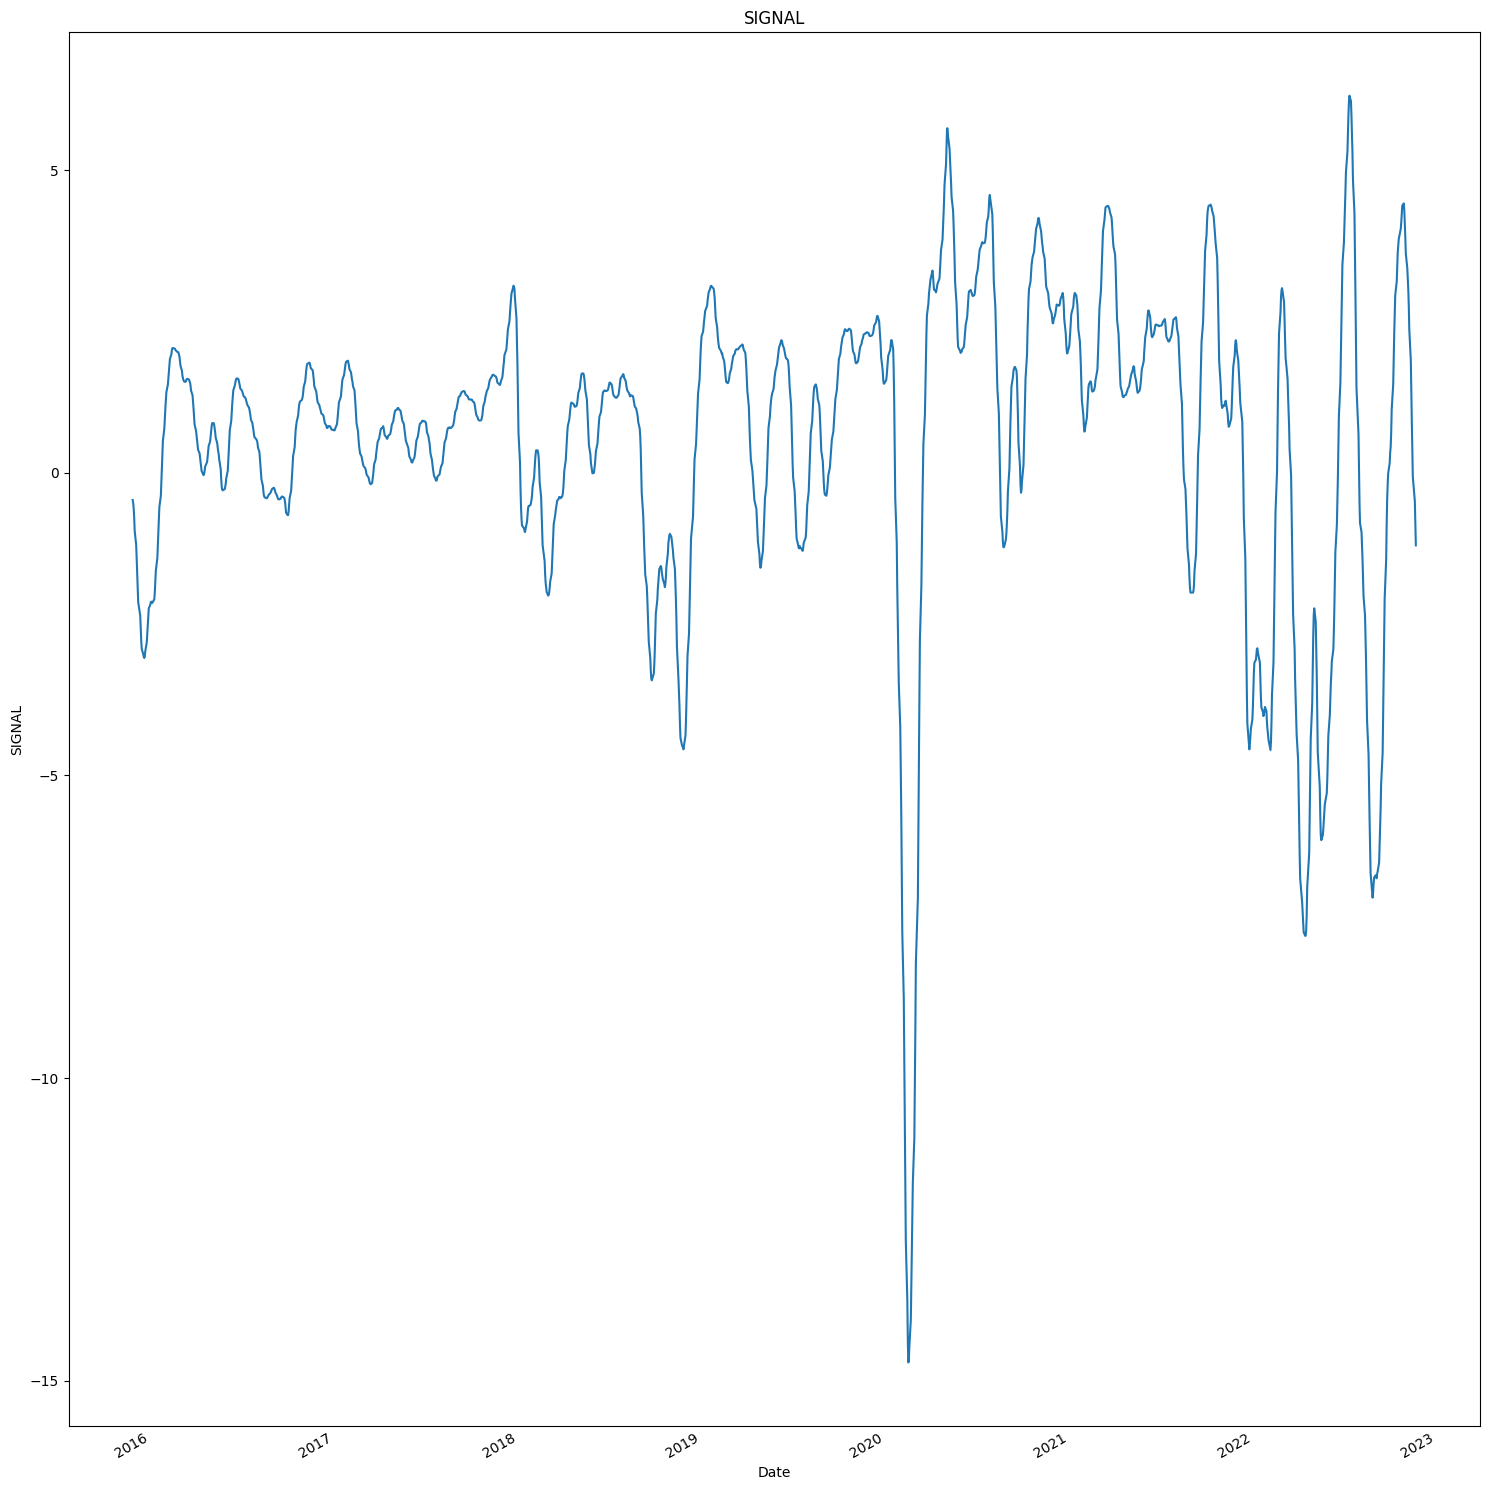

In [101]:


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [102]:
# Indexing Batches
df_train = df.sort_values(by=[date_col]).copy()
df_train.shape

(1761, 1)

In [103]:
def prepare_data(df):

    # List of considered Features
    FEATURES = feature_cols

    print(f'FEATURE LIST To Predict {prediction_col}')
    print([f for f in FEATURES])

    #Create the dataset with features and filter the data to the list of FEATURES"
    df_filter = df[FEATURES]
    
    print("Convert the data to numpy values")
    np_filter_unscaled = np.array(df_filter)
    np_filter_unscaled = np.reshape(np_filter_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_c_unscaled.shape)
    
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)   


print("Feature Data",np_filter_unscaled.shape)
print(np_filter_unscaled[:3])
print("Prediction Data",np_c_unscaled.shape)
print(np_c_unscaled[:3])

FEATURE LIST To Predict SIGNAL
['SIGNAL']
Convert the data to numpy values
(1761, 1)
(1761, 1)
Feature Data (1761, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]]
Prediction Data (1761, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]]


In [104]:
print(f"{input_sequence_length} = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction")
print(f"{output_sequence_length} = The output sequence length is the number of steps that the neural network predicts")

#How much ratio to split
index_Close = df_train.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_filter_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

80 = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction
10 = The output sequence length is the number of steps that the neural network predicts
Prediction Index = 0
0.8 = 1409 Split the training data into train and train data sets


In [105]:
print("Creating a separate scaler that works on a single column for scaling predictions")
print("Scale each feature to a range between 0 and 1")
scaler_train = MinMaxScaler()
print("Create a separate scaler for a single column")
scaler_pred = MinMaxScaler()


if split_way==1:
    print("Way#1 scale entire data and split data")   
    
    np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)
    
    print("All Data scaled for creating train and test data")    
    print(np_scaled.shape,np_scaled_c.shape)
    print(np_scaled_c[:5],np_scaled_c[:5])
    
    # Create the training and test data
    train_data =np_scaled[0:train_data_length, :]
    test_data = np_scaled[train_data_length - input_sequence_length:, :]

else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_filter_unscaled[0:train_data_length, :]
    test_data = np_filter_unscaled[train_data_length - input_sequence_length:, :]

    np_PredictVal_unScaled=np_c_unscaled[0:train_data_length]
    
    print("Train Data to be scaled") 
    print(train_data.shape,np_PredictVal_unScaled.shape)
    print(train_data[:5],np_PredictVal_unScaled[:5])
    
    train_data=scaler_train.fit_transform(train_data)
    test_data=scaler_train.transform(test_data)
    
    print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
    np_scaled=scaler_train.transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_PredictVal_unScaled)
    
    print("Predict val data(Scaled from Train data")
    print(np_scaled_c.shape)
    print(np_scaled_c[:3])
print("=========================================")       
print("Scaled data completely")
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])



Creating a separate scaler that works on a single column for scaling predictions
Scale each feature to a range between 0 and 1
Create a separate scaler for a single column
#Way#2 split data and apply  only train to scale
Train Data to be scaled
(1409, 1) (1409, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]
 [-0.74]
 [-0.96]] [[-0.45]
 [-0.5 ]
 [-0.59]
 [-0.74]
 [-0.96]]
For predict test that take the past 80 train value to predict the first test value
Predict val data(Scaled from Train data
(1409, 1)
[[0.698872  ]
 [0.69641981]
 [0.69200589]]
Scaled data completely
train and test data
(1409, 1) (432, 1)
[[0.698872  ]
 [0.69641981]
 [0.69200589]]
[[0.90485532]
 [0.9166258 ]
 [0.92594409]]


In [106]:
print("The RNN needs data with the format of [samples, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation ,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The RNN needs data with the format of [samples, time steps, features]


In [107]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and f features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



Here, we create 1409 samples, input_sequence_length time steps per sample, and f features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1319, 80, 1) (1319, 10)
(342, 80, 1) (342, 10)


# Step #4 Model Training

In [108]:
# Configure the neural network model
print(f"Train Row : {x_train.shape[0]}")

tf.random.set_seed(7)

model = Sequential()
n_output_neurons = output_sequence_length
#n_input_neurons=100 # tuned on vpc
      
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]

#n_input_neurons50
n_input_neurons =inputshape_Timestamps * no_feature
print(f"Model with n_neurons = inputshape Timestamps, each with feature variables {inputshape_Timestamps} x {no_feature} = {n_input_neurons} to predict {n_output_neurons}")

Train Row : 1319
Model with n_neurons = inputshape Timestamps, each with feature variables 80 x 1 = 80 to predict 10


In [109]:



model.add(LSTM(n_input_neurons, return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
model.add(Dense(n_output_neurons))

# Compile the model
#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 80)                26240     
                                                                 
 dense_5 (Dense)             (None, 10)                810       
                                                                 
Total params: 27,050
Trainable params: 27,050
Non-trainable params: 0
_________________________________________________________________


In [110]:

t_Start=time.time()
print(datetime.now())

if n_early==0:

 history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2
                   )
else:
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
                    
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2,callbacks=[early_stop]
                   )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

2022-12-30 23:01:19.369875
Epoch 1/100
42/42 - 8s - loss: 0.1334 - val_loss: 0.0481 - 8s/epoch - 193ms/step
Epoch 2/100
42/42 - 3s - loss: 0.0115 - val_loss: 0.0426 - 3s/epoch - 70ms/step
Epoch 3/100
42/42 - 3s - loss: 0.0109 - val_loss: 0.0428 - 3s/epoch - 74ms/step
Epoch 4/100
42/42 - 3s - loss: 0.0108 - val_loss: 0.0431 - 3s/epoch - 76ms/step
Epoch 5/100
42/42 - 3s - loss: 0.0107 - val_loss: 0.0425 - 3s/epoch - 72ms/step
Epoch 6/100
42/42 - 3s - loss: 0.0104 - val_loss: 0.0414 - 3s/epoch - 80ms/step
Epoch 7/100
42/42 - 3s - loss: 0.0101 - val_loss: 0.0400 - 3s/epoch - 73ms/step
Epoch 8/100
42/42 - 3s - loss: 0.0098 - val_loss: 0.0385 - 3s/epoch - 72ms/step
Epoch 9/100
42/42 - 3s - loss: 0.0095 - val_loss: 0.0369 - 3s/epoch - 76ms/step
Epoch 10/100
42/42 - 3s - loss: 0.0092 - val_loss: 0.0353 - 3s/epoch - 72ms/step
Epoch 11/100
42/42 - 3s - loss: 0.0088 - val_loss: 0.0336 - 3s/epoch - 75ms/step
Epoch 12/100
42/42 - 3s - loss: 0.0085 - val_loss: 0.0319 - 3s/epoch - 81ms/step
Epoch 13/

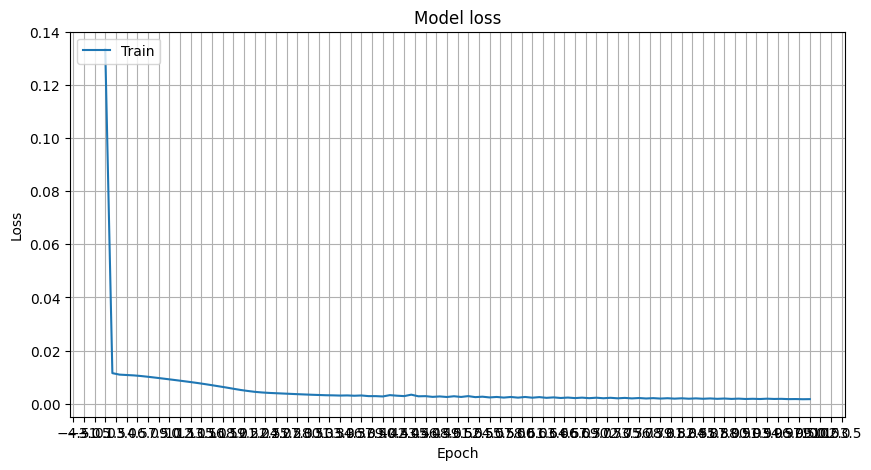

In [122]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

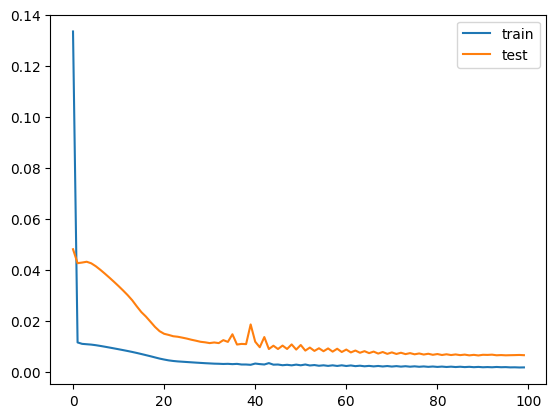

In [123]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [124]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train)
# shap_values = explainer.shap_values(x_test)

# Step #5 Evaluate Model Performance

In [125]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

11/11 [==============================] - 0s 32ms/step
(342, 10)
(342, 10)
(342, 10)


In [134]:
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 1.64
Mean Absolute Error (MAE): 1.2
Median Absolute Error (MAE): 1.2
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 30.01 %


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_10696\2545035638.py:14: RuntimeWarning: divide by zero encountered in divide
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_10696\2545035638.py:18: RuntimeWarning: divide by zero encountered in divide
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100


# Plot Multiple Forcast (Most Complex Step)

In [127]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



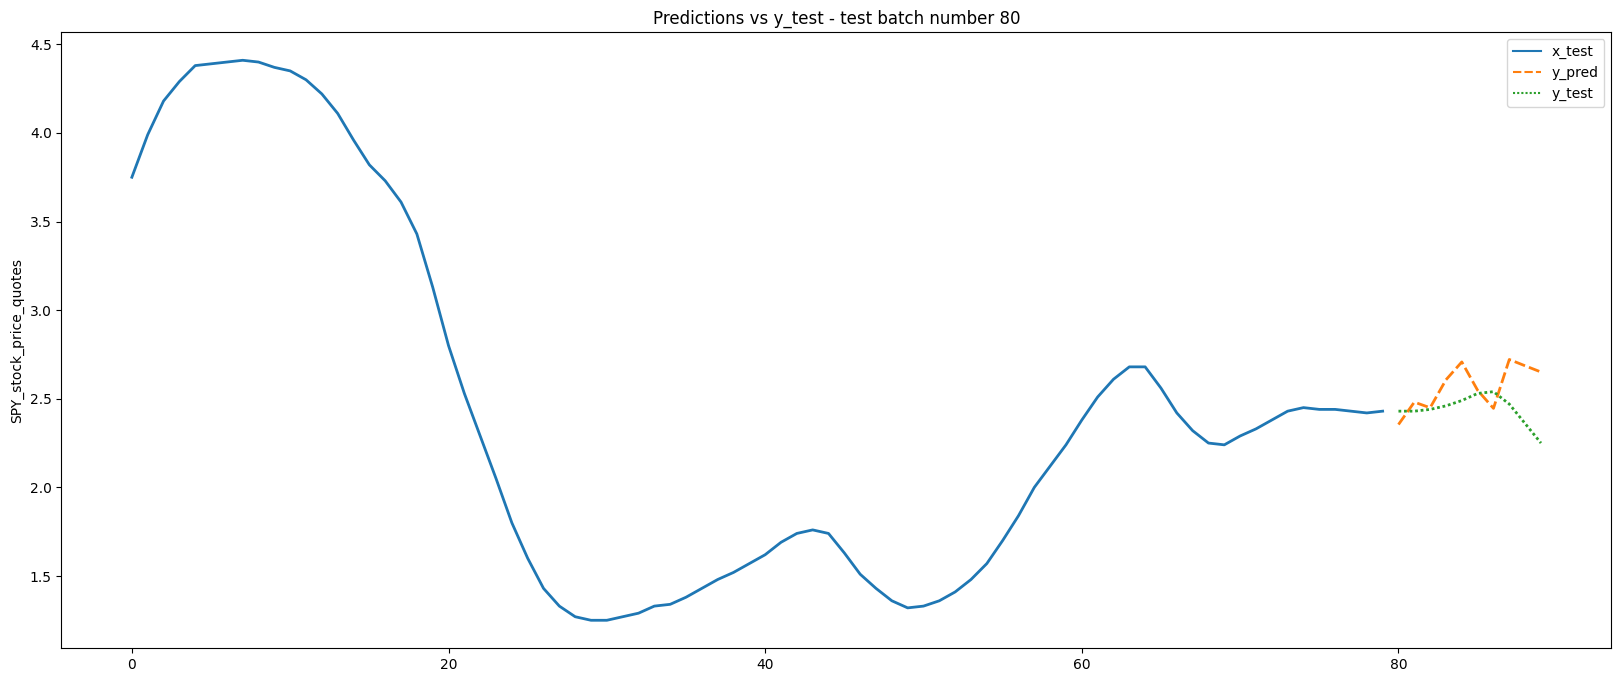

In [128]:
# Creates a linechart for a specific test batch_number and corresponding test predictions

x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {input_sequence_length}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

In [129]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

    
x_test_latest_batch

(1, 80, 1) is the latest input batch from the test dataset, which is contains the price values for the last 80 trading days


array([[[0.75232957],
        [0.72094164],
        [0.69641981],
        [0.68023541],
        [0.67287886],
        [0.66208926],
        [0.65080922],
        [0.637077  ],
        [0.62089259],
        [0.60519863],
        [0.58803335],
        [0.56841589],
        [0.54634625],
        [0.52035311],
        [0.49239823],
        [0.46395292],
        [0.4409024 ],
        [0.41883276],
        [0.39676312],
        [0.38106915],
        [0.37665522],
        [0.38057872],
        [0.38793526],
        [0.39283963],
        [0.39480137],
        [0.39431094],
        [0.39234919],
        [0.39578225],
        [0.39774399],
        [0.40510054],
        [0.41834232],
        [0.43403629],
        [0.44923982],
        [0.46885728],
        [0.49386954],
        [0.52427661],
        [0.55566454],
        [0.5860716 ],
        [0.61893085],
        [0.65031878],
        [0.67925454],
        [0.69936243],
        [0.71162334],
        [0.7204512 ],
        [0.72878862],
        [0

In [130]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 98ms/step
Predict on the inverse transformed batch (1, 10)
[[-1.0422666 -1.1010842 -1.5385212 -1.6589406 -1.692129  -1.8500319
  -1.9317816 -1.7029637 -1.7710798 -1.8048407]]


In [131]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (80, 1)
Y-Test= (10, 1)


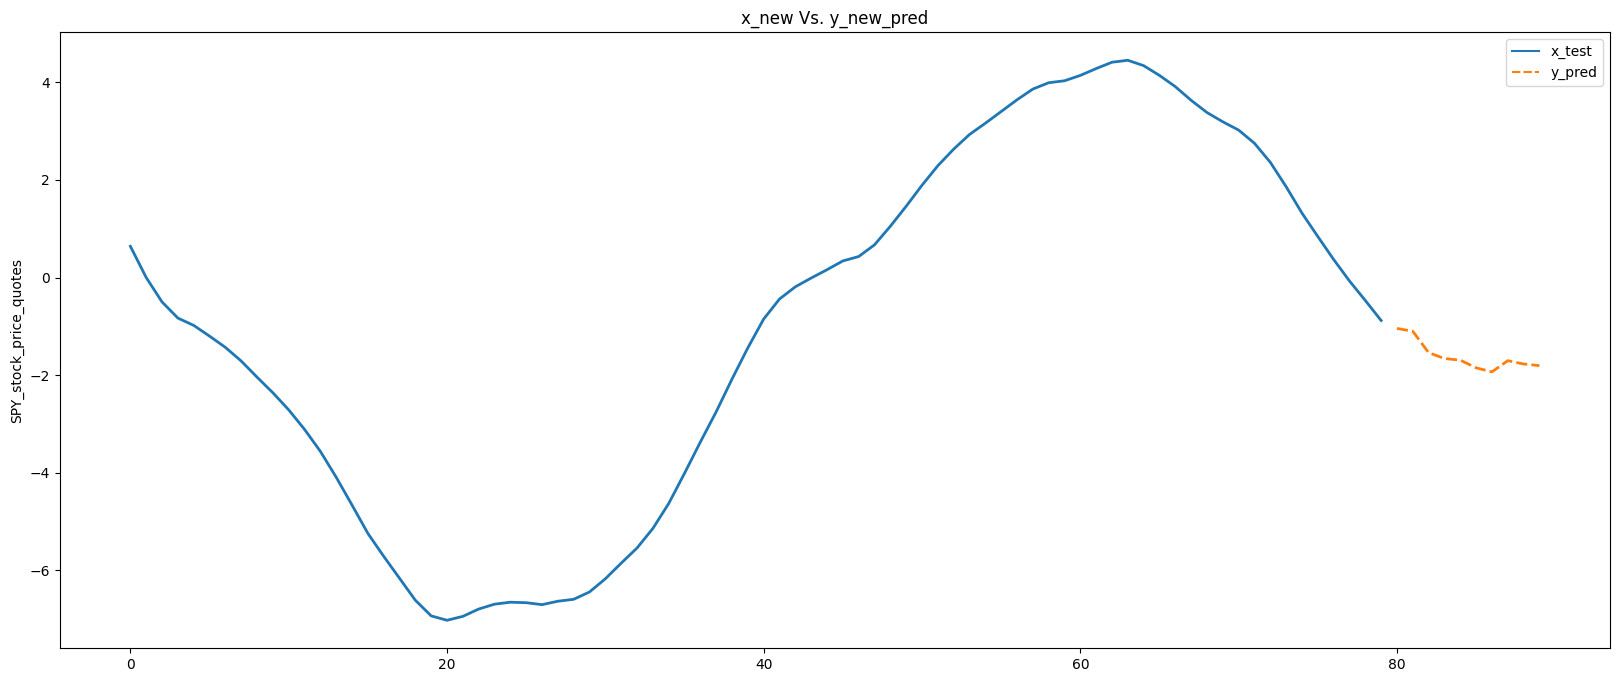

In [133]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")